In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import time
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelBinarizer

In [2]:
model = tf.keras.models.load_model('models/convlstm_model_Datetime_2022_05_26__23_52_24__loss_0.08553284406661987_acc_0.9906666874885559.h5')

FEATURES_PATH = "data/my_20_sec_features-additional_sites-2022_07_24__17_28_44.npy"
LABELS_PATH = "data/my_20_sec_labels-additional_sites-2022_07_24__17_28_44.npy"
SCALER_MAX = 709.0

SEED = 42

2023-05-20 11:05:28.390925: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)

with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)

In [4]:
features_scaled = features/SCALER_MAX
features_scaled.max()

1.8025387870239775

In [5]:
labels_order = [
    "www.amazon.co.uk",
    "www.bbc.co.uk",
    "www.ebay.co.uk",
    "www.facebook.com",
    "www.google.co.uk",
    "www.google.com",
    "www.twitter.com",
    "www.uwe.ac.uk",
    "www.wikipedia.com",
    "www.youtube.com",
]

In [6]:
labels_in_band = []
labels_out_of_band = []
features_in_band = []
features_out_of_band = []


for i in range(len(labels)):
    if labels[i] in labels_order:
        labels_in_band.append(labels[i])
        features_in_band.append(features_scaled[i])
    else:
        labels_out_of_band.append(labels[i])
        features_out_of_band.append(features_scaled[i])

labels_in_band = np.array(labels_in_band)
labels_out_of_band = np.array(labels_out_of_band)
features_in_band = np.array(features_in_band)
features_out_of_band=np.array(features_out_of_band)

print(f"labels_in_band - {labels_in_band.shape}")
print(f"labels_out_of_band - {labels_out_of_band.shape}")
print(f"features_in_band - {features_in_band.shape}")
print(f"features_out_of_band - {features_out_of_band.shape}")


labels_in_band - (2206,)
labels_out_of_band - (1054,)
features_in_band - (2206, 200, 150, 2)
features_out_of_band - (1054, 200, 150, 2)


In [7]:
label_binariser = LabelBinarizer()
label_binariser.fit(labels_order)
labels_encoded = label_binariser.transform(labels_in_band)
# labels_encoded = label_binariser.fit_transform(labels)
labels_encoded.shape

(2206, 10)

In [8]:
model_evaluation_history = model.evaluate(features_in_band, labels_encoded)


69/69 [==============================] - 27s 367ms/step - loss: 0.6628 - accuracy: 0.8495


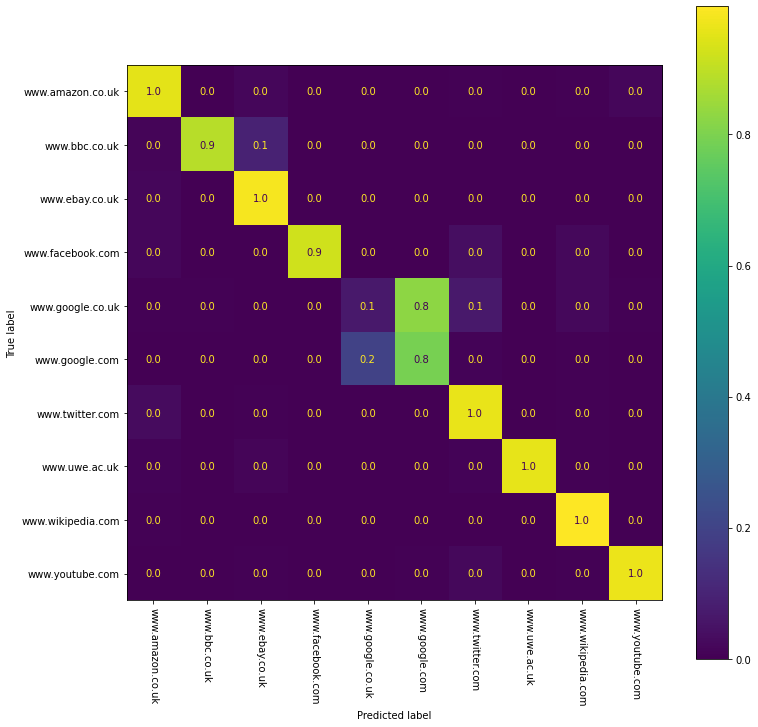

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       220
           1       0.99      0.89      0.94       207
           2       0.89      0.98      0.93       240
           3       1.00      0.92      0.96       233
           4       0.25      0.07      0.11       219
           5       0.51      0.79      0.62       236
           6       0.87      0.96      0.91       220
           7       1.00      0.96      0.98       202
           8       0.94      1.00      0.97       229
           9       0.97      0.96      0.97       200

    accuracy                           0.85      2206
   macro avg       0.83      0.85      0.83      2206
weighted avg       0.83      0.85      0.83      2206



In [9]:
fig, ax = plt.subplots(figsize=(12, 12))
y_true = np.argmax(labels_encoded, axis=1)
unique_y = np.unique(y_true)
predictions =  np.argmax(model.predict(features_in_band), axis=1)
cm = confusion_matrix(y_true, predictions, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
    )
disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
plt.show()
print(classification_report(y_true, predictions))

In [10]:
in_band_scores = model.predict(features_in_band)
out_of_band_scores = model.predict(features_out_of_band)

Text(0, 0.5, 'Number of prediction')

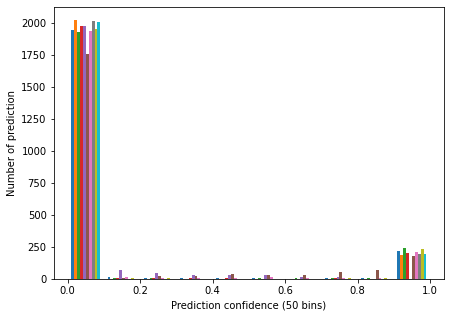

In [15]:
plt.figure(figsize=(7,5))
plt.hist(in_band_scores)
plt.xlabel("Prediction confidence (50 bins)")
plt.ylabel("Number of prediction")

Text(0, 0.5, 'Number of prediction')

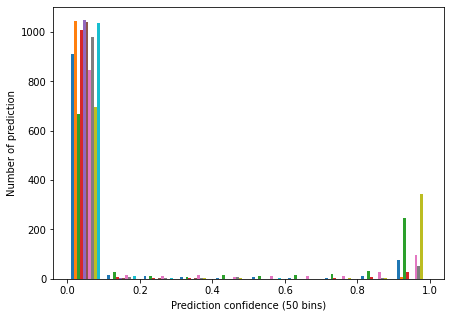

In [16]:
plt.figure(figsize=(7,5))
plt.hist(out_of_band_scores)
plt.xlabel("Prediction confidence (50 bins)")
plt.ylabel("Number of prediction")

In [15]:
len(out_of_band_scores)

1054

In [16]:
def get_band_score_delta_from_cut_off(cut_off, v=False):

    count_out_of_band = 0
    for score in out_of_band_scores:
        if score.max() > cut_off:
            count_out_of_band += 1
    out_of_band_above_cut_off = count_out_of_band/len(out_of_band_scores)

    if v:
        print(f"Out of band above cut-off - {out_of_band_above_cut_off}")

    count_in_band = 0
    for score in in_band_scores:
        if score.max() > cut_off:
            count_in_band += 1
    in_band_above_cut_off = count_in_band/len(in_band_scores)
    if v:
        print(f"In band above cut-off - {in_band_above_cut_off}")
    return in_band_above_cut_off - out_of_band_above_cut_off, in_band_above_cut_off

In [17]:
get_band_score_delta_from_cut_off(0.99, v=True)

Out of band above cut-off - 0.6062618595825426
In band above cut-off - 0.7030825022665458


(0.09682064268400314, 0.7030825022665458)

In [18]:
deltas = [get_band_score_delta_from_cut_off(i/100)[0] for i in range(50,100, 1)]
band_accuracy = [get_band_score_delta_from_cut_off(i/100)[1] for i in range(50,100, 1)]

Text(0.5, 0.98, 'Model confidence against threshold')

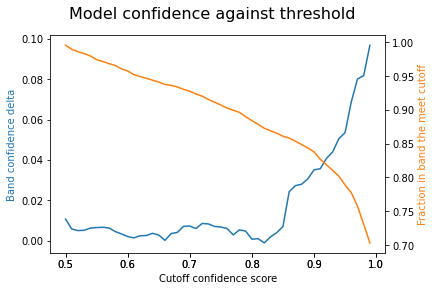

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)

ax.plot(np.arange(0.5, 1, 0.01), deltas, color="C0")
ax.set_ylabel("Band confidence delta", color="C0")
ax.set_xlabel("Cutoff confidence score", color="black")
ax2.plot(np.arange(0.5, 1, 0.01), band_accuracy, color="C1")
ax2.yaxis.tick_right()
ax2.set_ylabel("Fraction in band the meet cutoff", color="C1")
ax2.yaxis.set_label_position('right')

fig.suptitle('Model confidence against threshold', fontsize=16)


In [61]:
new_labels = np.array([label if label in labels_order else "Other" for label in labels])
new_features_scaled = features/SCALER_MAX
new_labels_order = [
    "www.amazon.co.uk",
    "www.bbc.co.uk",
    "www.ebay.co.uk",
    "www.facebook.com",
    "www.google.co.uk",
    "www.google.com",
    "www.twitter.com",
    "www.uwe.ac.uk",
    "www.wikipedia.com",
    "www.youtube.com",
    "Other"
]

In [62]:

del LabelBinarizer

from sklearn.preprocessing import LabelBinarizer

new_label_binariser = LabelBinarizer()
new_label_binariser.fit(new_labels_order)
new_labels_encoded = new_label_binariser.transform(new_labels)
# labels_encoded = label_binariser.fit_transform(labels)
new_labels_encoded.shape

(3260, 11)

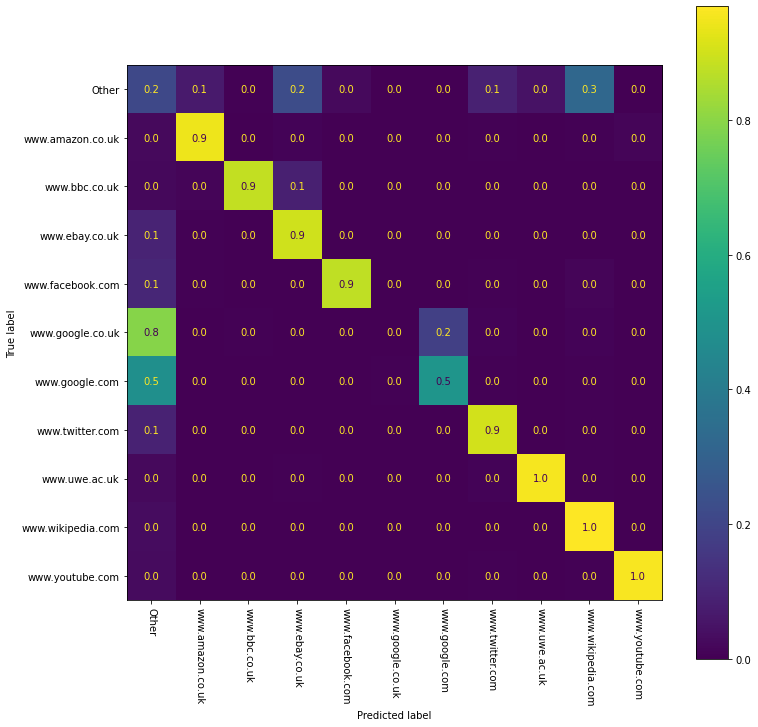

              precision    recall  f1-score   support

           0       0.37      0.21      0.27      1054
           1       0.72      0.95      0.82       220
           2       0.96      0.88      0.92       207
           3       0.45      0.90      0.60       240
           4       0.89      0.88      0.88       233
           5       0.00      0.00      0.00       219
           6       0.75      0.50      0.60       236
           7       0.66      0.90      0.76       220
           8       0.79      0.96      0.87       202
           9       0.39      0.97      0.55       229
          10       0.98      0.96      0.97       200

    accuracy                           0.60      3260
   macro avg       0.63      0.74      0.66      3260
weighted avg       0.56      0.60      0.55      3260



In [70]:
THRESHOLD = 0.91

fig, ax = plt.subplots(figsize=(12, 12))
y_true = np.argmax(new_labels_encoded, axis=1)
unique_y = np.unique(y_true)
predictions_scores = model.predict(new_features_scaled)
predictions = [np.argmax(score) +1 if score.max() > THRESHOLD else 0 for score in predictions_scores]
# +1 needed as the new_label_biniriser puts 'other' as the first value. THis is needed to offset the results from the model trained on 10 classes.
cm = confusion_matrix(y_true, predictions, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[new_label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
    )
disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
plt.show()
print(classification_report(y_true, predictions))
